# 05. Differential Photometry

Here I will demonstrate differential photometry for single-filter observation, which we have from KMTNet.

From [Note 3](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/03-Query.ipynb), we learnt how to query sidereal objects and the asteroid. In [Note 4](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/04-Aperture_Phot_01.ipynb), we learnt basics of aperture photometry.

Because many things can be tedious to learn and code, I here will use two packages:
* [``ysfitsutilpy`` package](https://github.com/ysBach/ysfitsutilpy): Convenience tools to manipulate FITS files
* [``ysphotutilpy`` package](https://github.com/ysBach/ysphotutilpy): Convenience tools for simple aperture photometry (PSF not supported yet)

**Please install these two.**

Here, I will show how to perform aperture photometry to the given field.

## 1. Importing and Setting Up
(You don't have to run the first code cell just below)

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, ccdproc, photutils, ysfitsutilpy, ysphotutilpy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-05-13 10:48:31 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 astropy    3.1.2
4 numpy      1.16.2
5 scipy      1.2.1
6 matplotlib 3.0.3
7 astroquery 0.3.9
8 ccdproc    1.3.0.post1
9 photutils  0.6
10 ysfitsutilpy 0.0.2.dev0
11 ysphotutilpy 0.0.2.dev0
12 version_information 1.0.3


In [2]:
from pathlib import Path
import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.time import Time
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
# from astropy.table import Table

from astroquery.jplhorizons import Horizons

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

from matplotlib import pyplot as plt
from matplotlib import rcParams

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import warnings
warnings.filterwarnings('ignore', append=True, category=UserWarning)

from matplotlib import pyplot as plt

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)



# Remove the next one line if you are not using Notebook (ipynb)
%matplotlib inline

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path('..') / 'data'

## 2. Load Data and Query

For details, please refer to [Note 03](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/03-Query.ipynb).

In [3]:
allfits = list(DATAPATH.glob("*.fits"))
allfits.sort()

hdul = fits.open(allfits[0])
hdr = hdul[0].header
data = hdul[0].data

# Set WCS and print for your information
w = WCS(hdr)

# Query object
objname = "4179"
observat = "B31"
t_obs = Time(hdr["DATE-OBS"]) + hdr["EXPTIME"] * u.s / 2
obj = Horizons(id=objname, location=observat, epochs=t_obs.jd)
obj_q = obj.ephemerides()

pos_sky = SkyCoord(obj_q["RA"][0], obj_q["DEC"][0], unit='deg')
pos_pix = pos_sky.to_pixel(wcs=w)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Below, I used ``yfu.center_radec`` and two of ``ypu`` functions.
1. ``center_radec`` takes ``header`` to extract the WCS information. Then if  ``center_of_image`` is ``True``, it calculates the RA/DEC value at the central pixel of the image. If it is ``False``, it just extracte the ``(header["RA"], header["DEC"])`` from the header.
2. ``panstarrs_query`` is the identical function of that in [Note 3](https://nbviewer.jupyter.org/github/ysbach/AO2019/blob/master/Notebooks/03-Query.ipynb). It takes the central RA/DEC and cone search radius in degrees unit.
3. ``xyinFOV`` calculates the image XY coordinate of the objects, and remove those outside of the FOV. This is done by the WCS that will be extracted from ``header``, and the queired result can directly be fed to ``table``. The ``ra_key`` and ``dec_key`` are the column names for the RA and DEC of that ``table``. The object must be within the width of ``bezel``. (Ex: ``bezel=100`` and image size is 1000 by 1000, then the objects outside of x = 100 to 900 and y = 100 to 900 are removed).

If you are interested in all the details, please see the source code. 

In [4]:
# Query sidereal objects (PS1)
cent_coord = yfu.center_radec(header=hdr, center_of_image=True)

rad = yfu.fov_radius(header=hdr, unit=u.deg)

result = ypu.panstarrs_query(cent_coord.ra.value, cent_coord.dec.value, radius=rad,
                             column_filters={"gmag":"13.0..20.0", "e_gmag":"<0.10"})

pos_stars = ypu.xyinFOV(header=hdr,
                       table=result,
                       ra_key="RAJ2000",
                       dec_key="DEJ2000",
                       bezel=50)

pos_stars

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,ymag,e_ymag,x,y
,deg,deg,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,
int64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64
96542043700069813,204.369958570,-9.542173820,0.0045,0.0045,18.5793,0.0094,17.7381,0.0083,17.3367,0.0075,17.1365,0.0057,17.0007,0.0144,431.2930760140192,86.47378776915866
96552043605265732,204.360481080,-9.537250170,0.0065,0.0136,18.9182,0.0112,18.6611,0.0173,18.5390,0.0104,18.5072,0.0070,18.5347,0.0220,515.6790029104372,131.42145048078783
96562043360882818,204.336024480,-9.531329940,0.0074,0.0071,17.8968,0.0045,17.5553,0.0064,17.4039,0.0052,17.3748,0.0061,17.3585,0.0054,734.3018163327216,185.6521180147347
96552043726118524,204.372557350,-9.534919320,0.0055,0.0064,18.3491,0.0051,18.1016,0.0070,18.0057,0.0088,18.0149,0.0148,17.9741,0.0159,407.18677718557853,152.40600020735565
96572044066809575,204.406640060,-9.517382090,0.0028,0.0036,16.9201,0.0031,16.5984,0.0029,16.4877,0.0020,16.4726,0.0036,16.4491,0.0081,100.02345920325676,311.08308555902113
96562043671322474,204.367066240,-9.531623650,0.0090,0.0127,19.5214,0.0094,18.8479,0.0121,18.5815,0.0147,18.4181,0.0091,18.3021,0.0223,456.0222738078955,182.4758917948975
96572043872939919,204.387235550,-9.517095530,0.0023,0.0041,16.2519,0.0021,16.0229,0.0031,15.9454,0.0032,15.9623,0.0035,15.9675,0.0069,273.7214362241896,314.13460705969646
96592043731934986,204.373110760,-9.504518530,0.0055,0.0879,18.9881,0.0052,17.8156,0.0158,16.3420,0.0047,15.6909,0.0079,15.3464,0.0030,398.854526619455,428.71480076890475


## 3. Star Matching

There are two ways to match the star you queried above with the object visible in the image.

1. You can find **star-like** objects in the image automatically. Then compare the positions of the stars you found from the image and the queried positions. 
2. Use the X Y coordinates from ``pos_stars`` above. Use it as the initial guess, crop the small portion (e.g., 7 by 7 pixel) of the image near the initial guess, and do centroiding at each position in the image iteratively until it converges.

The first way is a better choice, because (1) the star-finding algorithm is a well-established one, (2) what it does is superior to the crude centroiding algorithm you may use in the second approach.

For example, if the queried star has a large proper motion (say it moved 10 arcsec from J2000 to the current epoch, say J2020.2) and the image has small pixel scale, say 0.5 arcsec per pixel, so that your star is away from the queried position by more than 20 pixels. Then if you chose the second approach, what you have as the cropped region (7 by 7 pixel) does not contain the star. Then the centroiding algorithm will result in an unrealistic result. 

Thus, an easier way to match the stars are
1. Query the stars (say ``pos_stars``). _This is done above_.
2. Drop the stars with close distance, i.e., if there are more than 2 nearby stars (say ``pos_stars2``).
3. Find star-like objects in the image (say ``pos_found``).
4. Match the stars: find the closest items of ``pos_stars2`` and ``pos_found`` (say ``pos_matched``).

There is ``photutils`` documentation on [detecting objects](https://photutils.readthedocs.io/en/stable/detection.html). Here I will use the [``DAOStarFinder`` module](https://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html#photutils.DAOStarFinder), which is an implementation of the algorithm first developed by P. Stetson, and used extensively for the last 30-40 years by professional astronomers. This automatically finds the proper centroid of the stars, so we don't need any further centroiding process.

Here I used the following assumptions:
* From simple analysis, I found the FWHM of the point sources in the image is roughly 4 pixels. I will assume the seeing is fixed as 4 pixels.
* I will set aperture radius to 1.5 FWHM $ \sim 1.5 \times 4 = 6$ pixels, and the inner and outer radii of annuli to be 4 and 6 FWHM, which are 16 and 24 pixels, respectively. It means I am assuming that 6 pixels enoughly contains all the flux from the object, and the object does not affect pixels farther than 16 pixels away from its center.

### 3-1. Drop Nearby Stars

There are stars which are close to each other. These stars should not be used. I here will use [``DAOGroup`` of ``photutils``](https://photutils.readthedocs.io/en/stable/grouping.html), which uses the algorithm originally developed by P. Stetson in 1987.

The stars within ``crit_separation``, which I set as 6 times the FWHM (6 * 4 = 24 pixel), are regarded as "nearby stars" and grouped together.

In the code below, I used ``ypu.group_stars``. This takes the ``table`` which is astropy table object, which contains at least the image XY information of the stars. The ``crit_separation`` is the same as [``DAOGroup`` of ``photutils``](https://photutils.readthedocs.io/en/stable/grouping.html) (internally the code utilizes it). The ``xcol`` and ``ycol`` are the column names for the image X and Y values in the ``table``.

In [5]:
fwhm = 4
crit_sep = 6 * fwhm
nearby_stars = ypu.group_stars(table=pos_stars, 
                               crit_separation=crit_sep, 
                               xcol="x", 
                               ycol="y")
pos_stars2 = pos_stars.copy()  # Use ``copy`` to just copy the table
pos_stars2.remove_rows(nearby_stars)
print(f"After the removal, {len(pos_stars) - len(pos_stars2)} stars were removed out of {len(pos_stars)}.")

After the removal, 2 stars were removed out of 23.


Below I drew 
1. The originally queried stars by white circles.
2. The stars after "nearby-removal" by red circles.

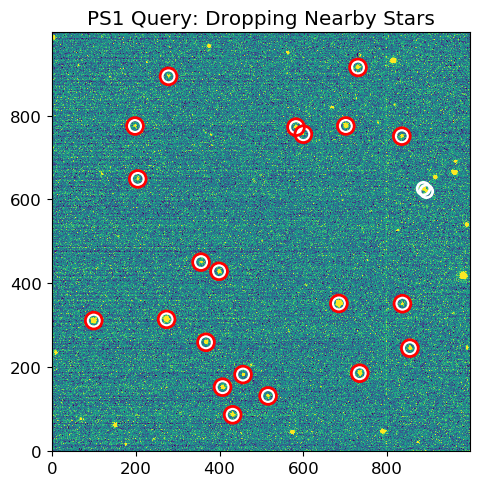

In [6]:
ap_stars = CAp(positions=(pos_stars["x"], pos_stars["y"]), r=15)
ap_stars2 = CAp(positions=(pos_stars2["x"], pos_stars2["y"]), r=20)

fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, hdul[0].data)
ap_stars.plot(color='w', lw=2)
ap_stars2.plot(color='r', lw=2)

axs.set_title("PS1 Query: Dropping Nearby Stars")
plt.tight_layout()

### 3-2. Star Finder

The following code will find star-like objects in the FOV.

I set the threshold for the detection to be pixel-wise S/N ratio of roughly 5.

I did the same dropping nearby star process here too, because if the stars detected in the image are nearby, they must not be used. 

* **TIP**: Some may ask why this is necessary because we have already dropped nearby stars in previous step. In the previous step, we dropped nearby stars based solely on the catalogued positions. Some objects may be bright enough but not catalogued for some reason, so they are detected only by this star finding process. In unfortunate cases, such stars may be near to the star that we may have expected to be "isolated" from the nearby object removal in the above. What if we skip the above process but drop stars only based on the star finding algorithm? There might be faint object which were bright enough to be catalogued, but unfortunately unresolved in our image. Then as they are not distinguishable  in our image, our instrumental  magnitude will be the sum of the objects, while we will use the catalogue magnitude of only one of the overlapping stars. Thus, the two processes are both necessary.

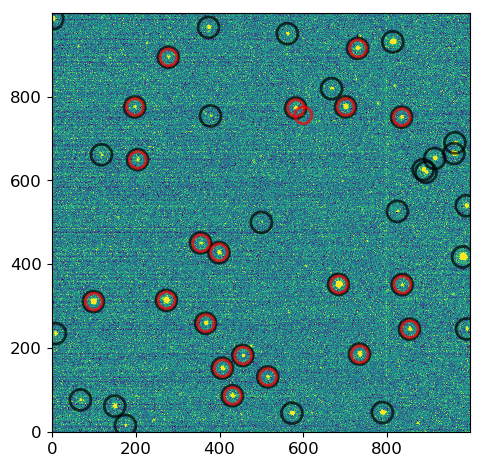

In [7]:
avg, med, std = sigma_clipped_stats(data) # default is 3-sigma, 5 iters
thresh = 5 * std
finder = DAOStarFinder(fwhm=4, threshold=thresh,   # In reality, FWHM must be measured a priori using, e.g., ``ginga``
                       sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
                       roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
                       sigma_radius=1.5,           # default values 1.5
                       ratio=1.0,                  # 1.0: circular gaussian
                       exclude_border=True)        # To exclude sources near edges

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
found = finder(data)

# Use ``found`` for aperture photometry:
coords_SF = (found['xcentroid'], found['ycentroid'])
ap_found = CAp(coords_SF, r=25)  

# Plot all
fig, axs = plt.subplots(1, 1, figsize=(5, 6), sharex=False, sharey=False, gridspec_kw=None)
zimshow(axs, data)
ap_found.plot(color='k', lw=2, alpha=0.7)
ap_stars2.plot(color='red', lw=2, alpha=0.7)

axs.set
plt.tight_layout()

* **HOMEWORK**: Change ``roundlo=-1.0, roundhi=1.0``, to ``roundlo=-.5, roundhi=.5``, then see our object, at the center of image, is not detected from star finder. This happens _partly_ because the observation was made in non-sidereal tracking mode, i.e., the moving object (our asteroid) become slightly elliptical on the CCD (i.e., its ``round`` parameter gets larger). Note that some of the stars are undetected too.

### 3-3. Drop Stars with No Nearby Object in the Image

Now I want to select the "overlapping" stars. For each of the positions that we have obtained from the query, I will check whether there is a star from star-finding algorithm nearby it. If there is no such star nearby the queried XY position (say within 5 pixels), I will regard that queried position as unreliable position. This can happen, e.g., because the star is too faint to be imaged as star-like object in our observation. To do this, we have to initialize some of the columns. Then I calculated the "pixel shift", i.e., the distance between the queried and star-finding algorithm positions. This must be at most around 1 pixel order or smaller than seeing disc size.

In [16]:
# Set the maximum allowable distance
match_distance = 5 # pixel

# Initialize some columns
pos_stars2["xcentroid"] = 0.
pos_stars2["ycentroid"] = 0.
pos_stars2["peak"] = 0.
pos_stars2["pixel_shift"] = match_distance + 1.

for i, coo in enumerate(pos_stars2):
    dx = np.abs(found['xcentroid'] - coo['x'])
    dy = np.abs(found['ycentroid'] - coo['y'])
    distances = np.sqrt(dx**2 + dy**2)
    accepted_SF = found[distances < match_distance]
    if len(accepted_SF) == 0:
        continue
    else:
        pos_stars2[i]["pixel_shift"] = distances.min()
        pos_stars2[i]["xcentroid"] = found[distances.argmin()]["xcentroid"]
        pos_stars2[i]["ycentroid"] = found[distances.argmin()]["ycentroid"]
        pos_stars2[i]["peak"] = found[distances.argmin()]["peak"]

# Select only those which are matched
matched = pos_stars2[pos_stars2["pixel_shift"] < match_distance]

# Conversion to V-mag (see notebook 3)
matched["Vmag"] = matched["gmag"] - 0.5784 * (matched["gmag"] - matched["rmag"]) - 0.0038

In [17]:
matched

objID,RAJ2000,DEJ2000,e_RAJ2000,e_DEJ2000,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,ymag,e_ymag,x,y,xcentroid,ycentroid,peak,pixel_shift,Vmag
,deg,deg,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,mag
int64,float64,float64,float64,float64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float64,float64,float64,float64,float64,float64,float64
96542043700069813,204.369958570,-9.542173820,0.0045,0.0045,18.5793,0.0094,17.7381,0.0083,17.3367,0.0075,17.1365,0.0057,17.0007,0.0144,431.2930760140192,86.47378776915866,430.4018592260251,86.51553682770485,380.33221435546875,0.8921941196242035,18.0889
96552043605265732,204.360481080,-9.537250170,0.0065,0.0136,18.9182,0.0112,18.6611,0.0173,18.5390,0.0104,18.5072,0.0070,18.5347,0.0220,515.6790029104372,131.42145048078783,514.8524194871211,131.52197357540348,251.6754608154297,0.8326734343379494,18.7657
96562043360882818,204.336024480,-9.531329940,0.0074,0.0071,17.8968,0.0045,17.5553,0.0064,17.4039,0.0052,17.3748,0.0061,17.3585,0.0054,734.3018163327216,185.6521180147347,733.5470610224448,185.89460494929742,520.4367065429688,0.7927518475693514,17.6955
96552043726118524,204.372557350,-9.534919320,0.0055,0.0064,18.3491,0.0051,18.1016,0.0070,18.0057,0.0088,18.0149,0.0148,17.9741,0.0159,407.18677718557853,152.40600020735565,406.4793583109283,152.46672935445622,337.0688781738281,0.71002076977997,18.2021
96572044066809575,204.406640060,-9.517382090,0.0028,0.0036,16.9201,0.0031,16.5984,0.0029,16.4877,0.0020,16.4726,0.0036,16.4491,0.0081,100.02345920325676,311.08308555902113,99.22211147495238,311.1891725798401,1182.3135986328125,0.8083394321971622,16.7302
96562043671322474,204.367066240,-9.531623650,0.0090,0.0127,19.5214,0.0094,18.8479,0.0121,18.5815,0.0147,18.4181,0.0091,18.3021,0.0223,456.0222738078955,182.4758917948975,455.37932829014983,182.60187682295032,210.6496124267578,0.6551726231175267,19.1280
96572043872939919,204.387235550,-9.517095530,0.0023,0.0041,16.2519,0.0021,16.0229,0.0031,15.9454,0.0032,15.9623,0.0035,15.9675,0.0069,273.7214362241896,314.13460705969646,273.12538192454616,314.13736718303613,2054.874755859375,0.5960606902021384,16.1156
96592043731934986,204.373110760,-9.504518530,0.0055,0.0879,18.9881,0.0052,17.8156,0.0158,16.3420,0.0047,15.6909,0.0079,15.3464,0.0030,398.854526619455,428.71480076890475,398.6206222937924,428.02223607651956,315.5675354003906,0.7309973233208622,18.3061


As can be seen, there are now 20 stars that can be used. Before the dropping, there were 21 stars, so one star is removed.

* **QUESTION**: Can you see which is that removed star? Find an object with red circle but no black circle in the previous figure.

## 4. Aperture Photometry

The idea of photometry is not that difficult. The tricky part is to realize that calculation in computer. How can we calculate the pixel sum for non-rectangular aperture (e.g., circle)? How can I chop the *sky regions* from the CCD image? Things should have been easier in theoretical approach, but it gets extremely tricky and difficult for those who are not so accustomed to programming (including myself). Here, I will use a simple personal package that I use from time to time, and just show the results, because you all now know how those are calculated.

In [10]:
ccd = yfu.load_ccd(path=allfits[0])
err = yfu.make_errmap(ccd=ccd, gain_epadu=hdr["GAIN"], rdnoise_electron=hdr["RDNOISE"])
fwhm = 4
r_ap = fwhm * 2
r_in = fwhm * 4
r_out = fwhm * 6

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Although you should do a more careful calculation, I here will use the star-finder algorithm's resulting object position as the image center of our target. There is only one single such object for `498 < xcentroid < 502` and `498 < ycentroid < 502`:

In [11]:
found_targ = found[(498 < found["xcentroid"]) & (found["xcentroid"] < 502)
                   & (498 < found["ycentroid"]) & (found["ycentroid"] < 502)]
found_targ

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
22,499.83981113253833,500.1257789558218,0.35659654523865975,-0.9099048107312524,-0.9963898704571613,25,0.0,114.02897644042969,1.0041876370849463,-0.004537175789310933


In [13]:
pos_star_match = (matched["xcentroid"], matched["ycentroid"])
pos_targ = (found_targ["xcentroid"], found_targ["ycentroid"])

star_ap = CAp(positions=pos_star_match, r=r_ap)
star_an = CAn(positions=pos_star_match, r_in=r_in, r_out=r_out)

targ_ap = CAp(positions=pos_targ, r=r_ap)
targ_an = CAn(positions=pos_targ, r_in=r_in, r_out=r_out)

phot_star = ypu.apphot_annulus(ccd=ccd,
                               aperture=star_ap,
                               annulus=star_an,
                               error=err)

phot_targ = ypu.apphot_annulus(ccd=ccd,
                               aperture=targ_ap,
                               annulus=targ_an,
                               error=err)

Ignore any uncertainty extension in the original CCD and use provided error.
Ignore any uncertainty extension in the original CCD and use provided error.


In [14]:
phot_star

id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,nrej,nsky,ssky,source_sum,source_sum_err,mag,merr
,pix,pix,,,,,,,,,,
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64
1,430.4018592260251,86.51553682770485,25082.360607217983,138.1943180356853,82.38687850906327,2,999,8.45701155325767,8517.495821536831,148.31612221085157,-5.3804016970067075,0.01890604785815997
2,514.8524194871211,131.52197357540348,21247.96803494424,129.2330229974107,83.71351121481561,2,1006,8.320545667174843,4416.367917269265,139.6021802288512,-4.667284989752273,0.03432031573840274
3,733.5470610224448,185.89460494929742,29239.86905412034,147.29600222938186,82.45693826006504,6,998,8.510980035942977,12660.91791969938,156.99697391377256,-5.81078485724283,0.013463265435946987
4,406.4793583109283,152.46672935445622,24427.016534935043,136.704350637148,81.33533813014174,5,990,8.53034250996239,8073.57648713376,147.2227476119771,-5.322286784124172,0.019798544982019405
5,99.22211147495238,311.1891725798401,47618.87711091704,182.16199474698544,82.56866254064137,2,1002,8.654307448103264,31017.462477034565,190.29128316015158,-6.7836375378365075,0.006660961892992677
6,455.37932829014983,182.60187682295032,19465.91491424964,124.84947352771454,82.70917351088838,3,1002,8.639186623056265,2836.248873527049,136.4097516336364,-4.186482715051614,0.052218621367498615
7,273.12538192454616,314.13736718303613,71832.82074831476,219.81061689662548,82.95019843779414,5,996,8.39112346424176,55154.69377065142,226.24982631647967,-7.4085780681551014,0.004453793702010419
8,398.6206222937924,428.02223607651956,23625.506979548627,134.8596903402982,81.82680972893081,6,1002,8.190775333943815,7173.2507036382995,144.60343448688752,-5.193911898049891,0.02188703429466817


In [15]:
phot_targ

id,xcenter,ycenter,aperture_sum,aperture_sum_err,msky,nrej,nsky,ssky,source_sum,source_sum_err,mag,merr
,pix,pix,,,,,,,,,,
int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64
1,499.83981113253833,500.1257789558218,17254.900494349302,119.18685809336817,81.74767253643732,2,1003,8.354325262948034,818.5556950830251,130.47683329804465,-2.83724246014971,0.17306509825151162


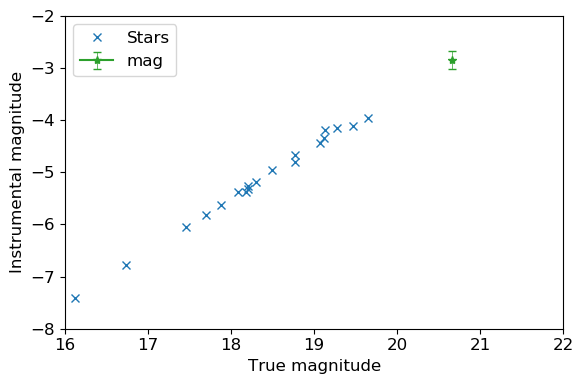

In [39]:
from scipy.optimize import curve_fit
def linf(x, b):
    return x + b

popt, pcov = curve_fit(linf, xdata=matched["Vmag"], ydata=phot_star["mag"])

xx = np.arange(15, 25, 1)

fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

axs.plot(matched["Vmag"], phot_star["mag"], 'x', label="Stars")
axs.plot([15, 25], )
axs.errorbar(phot_targ["mag"] - popt, phot_targ["mag"], yerr=phot_targ["merr"],
            marker="*", capsize=3, elinewidth=0.5)
axs.set_xlabel("True magnitude")
axs.set_ylabel("Instrumental magnitude")
axs.set_xlim(16, 22)
axs.set_ylim(-8, -2)
axs.legend()
plt.tight_layout()


In [34]:
phot_targ["mag"] - popt

20.65985909427754
